In [1]:
# this chemkin file is from the cti generated by rmg

# load a bunch of stuff
from __future__ import division
# load
import cantera as ct
import numpy as np
import scipy
import pylab
import matplotlib
import matplotlib.pyplot  as plt
import matplotlib.gridspec as gridspec
from matplotlib.ticker import NullFormatter, MaxNLocator, LogLocator
import csv
from pydas.dassl import DASSL
import os
%matplotlib inline

array = os.listdir('../cpox-cti')
files = ['../cpox-cti/' + x for x in array]

a = 9

gas = ct.Solution(files[a],'gas')
surf = ct.Interface(files[a],'surface1', [gas])
print "This mechanism contains %d gas reactions and %d surface reactions for the linear scaling file %s"%(gas.n_reactions, surf.n_reactions, array[a])
i_n2 = gas.species_index('N2')
i_ch4 = gas.species_index('CH4(2)')
i_o2 = gas.species_index('O2(3)')
i_co2 = gas.species_index('CO2(4)')
i_h2o = gas.species_index('H2O(5)')
i_h2 = gas.species_index('H2(6)')
i_co = gas.species_index('CO(7)')

This mechanism contains 0 gas reactions and 209 surface reactions for the linear scaling file 2.000o-1.500.cti


  1.000000e-04    0.100000    0.100000    0.800000
  2.238721e-04    0.100000    0.100000    0.800000
  5.011872e-04    0.100000    0.100000    0.800000
  1.122018e-03    0.100000    0.100000    0.800000
  2.511886e-03    0.100000    0.100000    0.800000
  5.623413e-03    0.100000    0.100000    0.800000
  1.258925e-02    0.100000    0.100000    0.800000
  2.818383e-02    0.100000    0.100000    0.800000
  6.309573e-02    0.100000    0.100000    0.800000
  1.412538e-01    0.100000    0.100000    0.800000
  3.162278e-01    0.100000    0.100000    0.800000
  7.079458e-01    0.100000    0.100000    0.800000
  1.584893e+00    0.100000    0.100000    0.800000
  3.548134e+00    0.100000    0.100000    0.800000
  7.943282e+00    0.100000    0.100000    0.800000
  1.778279e+01    0.099999    0.100000    0.800000
  3.981072e+01    0.099999    0.099999    0.800001
  8.912509e+01    0.099998    0.099998    0.800002
  1.995262e+02    0.099995    0.099993    0.800008
  4.466836e+02    0.099990    0

Text(0.5,0,u'Time(s)')

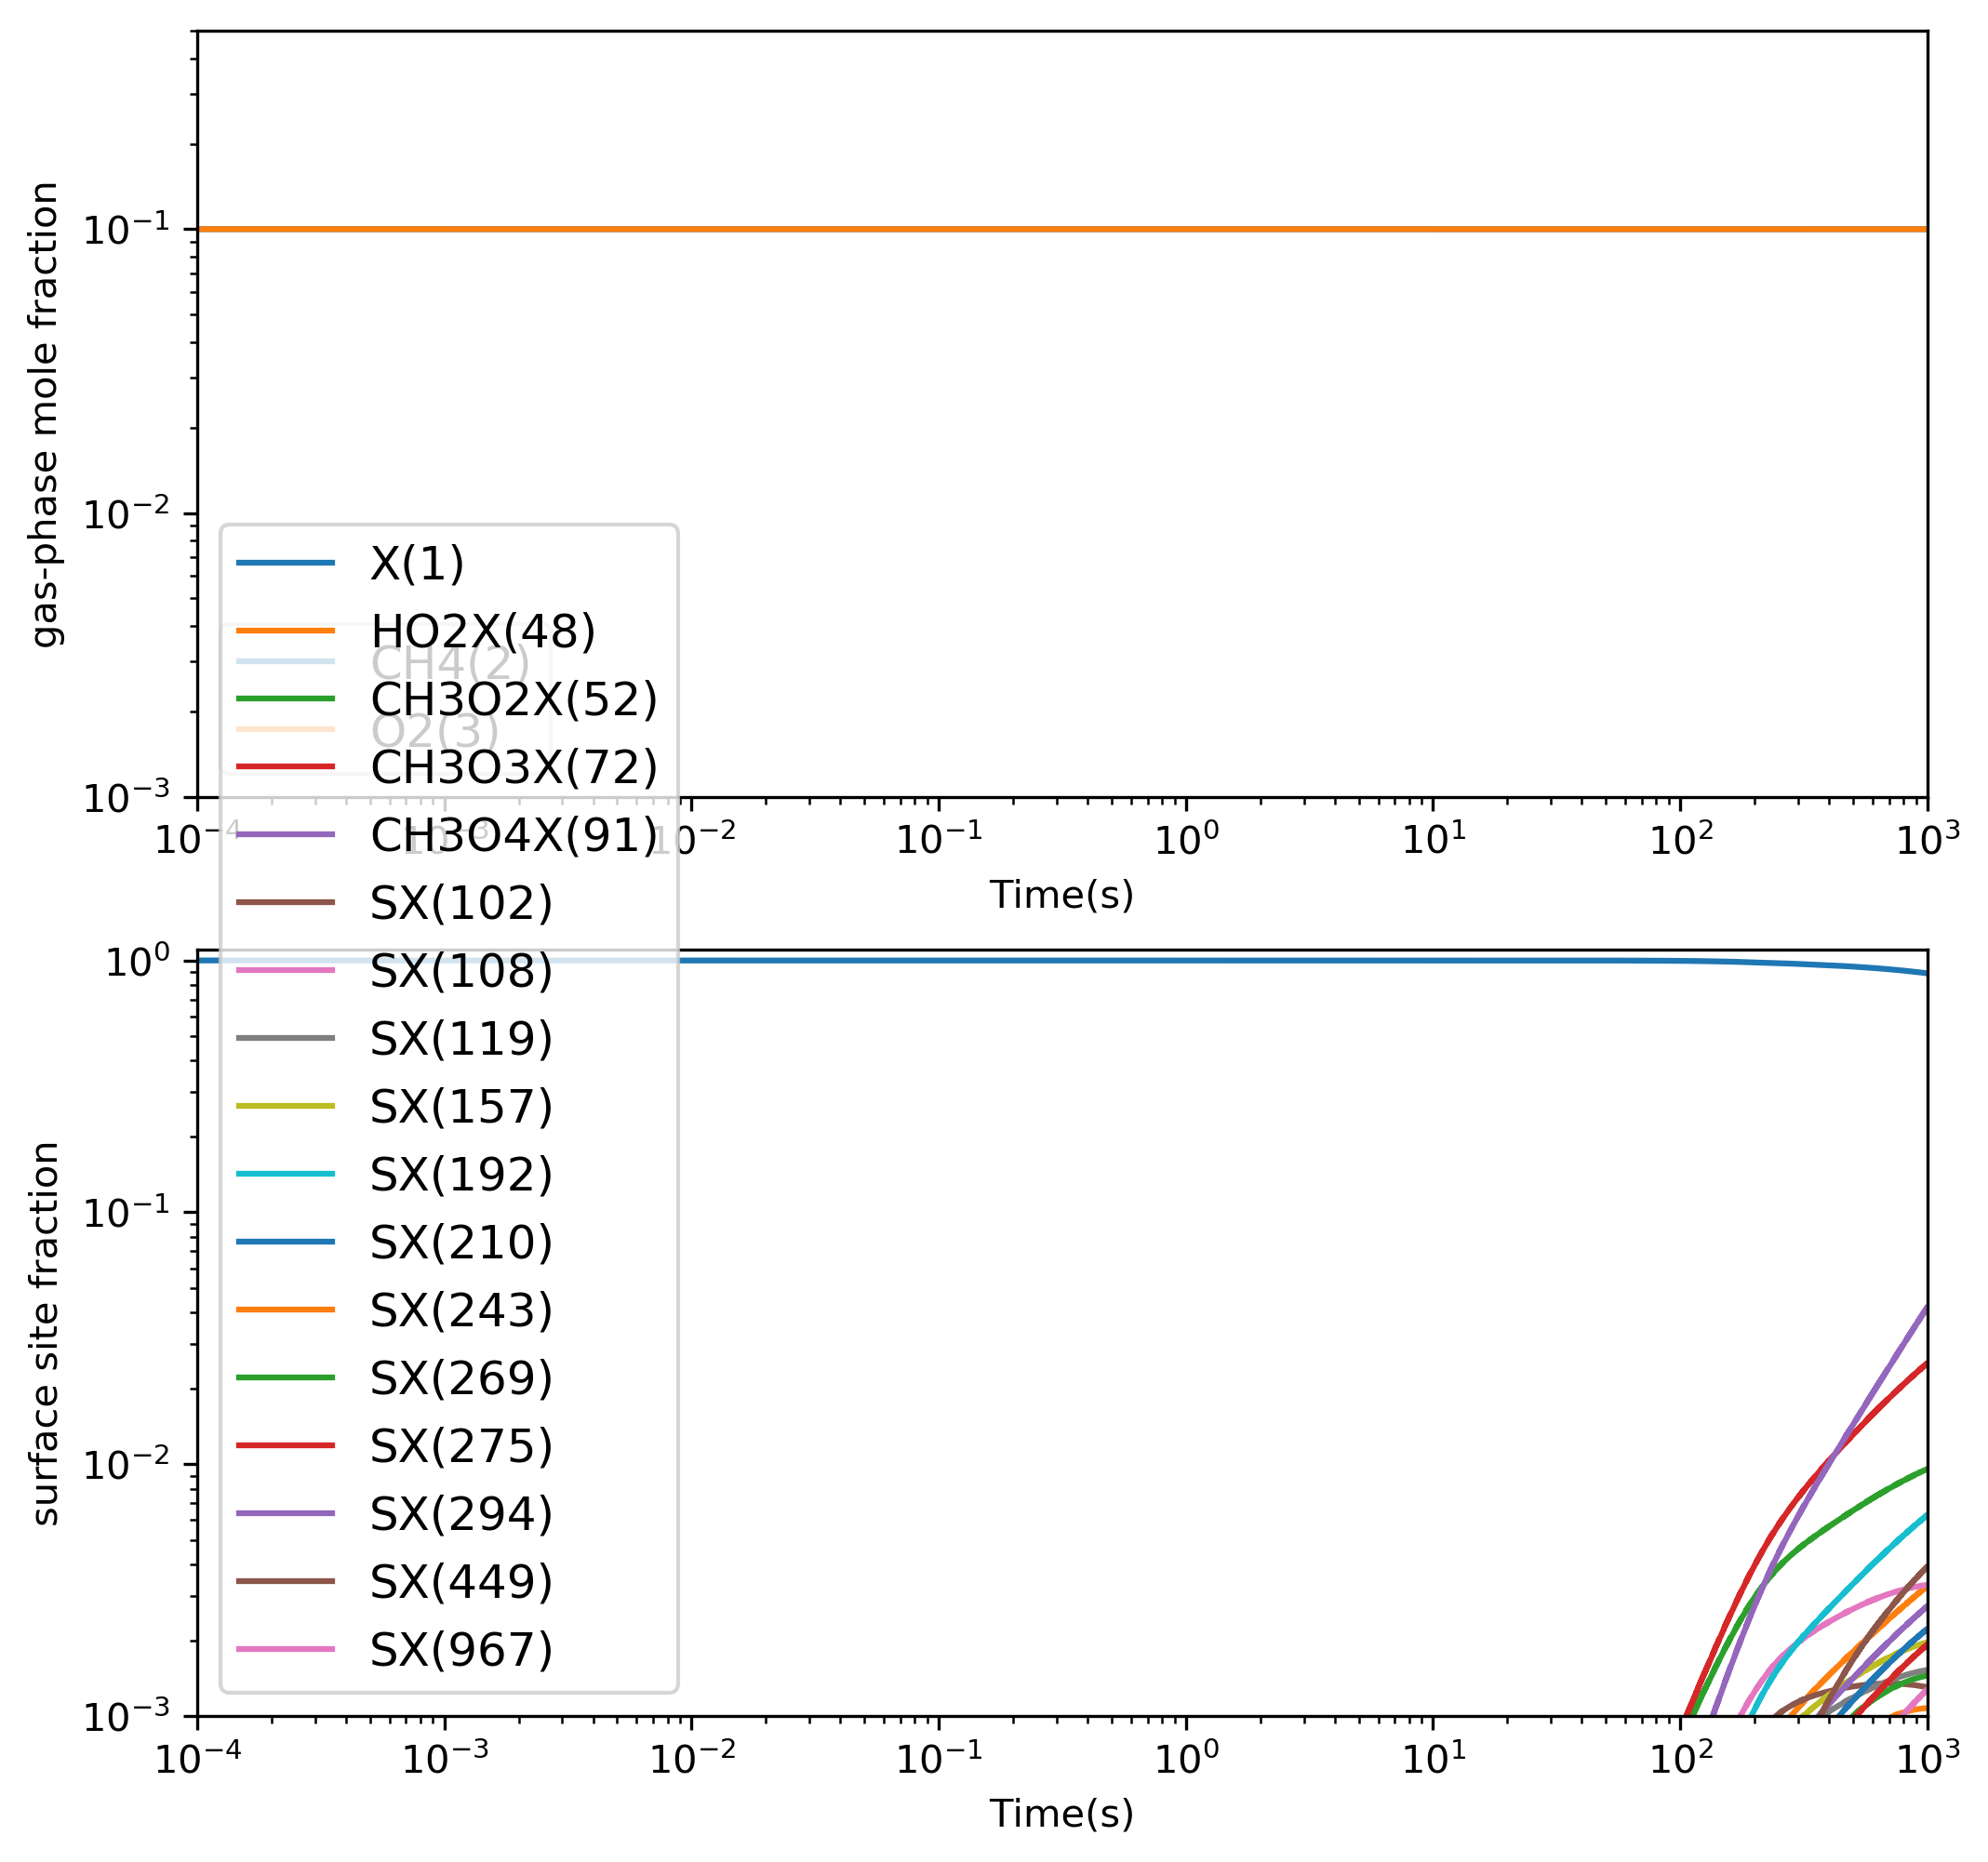

In [2]:
#######################################################################
# Input Parameters
#######################################################################

volume = 1.0
cat_area_per_vol = 1.0E2 #I made this up!

cat_area = cat_area_per_vol * volume

#initial conditions
T0 = 800.
P0 = 1.0 #bar
#initial composition (gas mol fraction)
CH4_0 = 0.1
O2_0 = 0.1
N2_0 = 0.8
CO2_0 = 0.

gas.TPX = T0, P0 * ct.one_atm, {'CH4(2)':CH4_0, 'O2(3)':O2_0, 'N2':N2_0, 'CO2(4)':CO2_0}
          #Temp, Pressure, mole fraction
surf.TP = T0, P0 * ct.one_atm
surf.coverages = {'X(1)':1.0}
#surf.coverages = {'PT(S)':0.9, 'O(S)':0.1}

r = ct.IdealGasConstPressureReactor(gas, energy='off')
r.volume = volume
rsurf = ct.ReactorSurface(surf, r, A=cat_area) # A=cat_area

sim = ct.ReactorNet([r])
sim.max_err_test_fails = 12

# set relative and absolute tolerances on the simulation
sim.rtol = 1.0e-12
sim.atol = 1.0e-18

#rxn_time = np.linspace(1E-12, 5, 10001) #
rxn_time = np.logspace(-4, 3, 10001) #from 0s to 100s, log spacing

gas_mole_fracs = np.zeros([gas.n_species, len(rxn_time)])
surf_site_fracs = np.zeros([surf.n_species, len(rxn_time)])
temperature = np.zeros(len(rxn_time))    
pressure = np.zeros(len(rxn_time))   

for i in range(len(rxn_time)):
    time = rxn_time[i] #define time in the reactor
    sim.advance(time) #Advance the simulation to next set time
    temperature[i] = gas.T
    pressure[i] = gas.P/ct.one_atm
    gas_mole_fracs[:,i] = gas.X #
    surf_site_fracs[:,i] = surf.coverages #
    if not i % 500:
        print('  {0:10e}  {1:10f}  {2:10f}  {3:10f}'.format(time, *gas['CH4(2)','O2(3)','N2'].X))



#sim.advance_to_steady_state()
#print('  {0:10e}  {1:10f}  {2:10f}  {3:10f}'.format(sim.time, *gas['CH4','H2','CO'].X))    
    
CH4_ref = gas_mole_fracs[i_ch4,:]

#Plot out simulations results
fig = pylab.figure(dpi=300,figsize=(8,8))
gs = gridspec.GridSpec(2, 1)
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])

y_min = 1E-3

for i in range(gas.n_species):
    if i != i_n2:
        if np.max(gas_mole_fracs[i,:]) > y_min:
            ax0.loglog(rxn_time, gas_mole_fracs[i,:], label=gas.species_name(i) )

for i in range(surf.n_species):
    if np.max(surf_site_fracs[i,:]) > y_min:
        ax1.loglog(rxn_time, surf_site_fracs[i,:], label=surf.species_name(i) )
            
ax0.legend(loc='lower left', fontsize = 12)
ax1.legend(loc='lower left', fontsize = 12)

ax0.set_ylabel("gas-phase mole fraction")
ax0.set_ylim(y_min,0.5)
ax0.set_xlim(1.0E-4,max(rxn_time))
ax1.set_xlim(1.0E-4,max(rxn_time))
ax0.set_xlabel("Time(s)")
ax1.set_ylabel("surface site fraction")
#ax0.xaxis.set_major_locator(MaxNLocator(6))
#ax0.yaxis.set_major_locator(LogLocator(base=10.0, numticks=3))
#ax0.tick_params(axis='both', which='major', labelsize=10)
ax1.set_ylim(y_min, 1.1 )
ax1.set_xlabel("Time(s)")


In [3]:
# Set the value of the perturbation
dk = 1.0e-2
# create the array to hold the sensitivty at each time step
Sensitivity = np.zeros([surf.n_reactions,len(rxn_time)])

#cycle through each reaction
for m in range(surf.n_reactions):
    surf.set_multiplier(1.0) # reset all multipliers  
    surf.set_multiplier(1+dk, m) # perturb reaction m
    
    gas.TPX = T0, P0 * ct.one_atm, {'CH4(2)':CH4_0, 'O2(3)':O2_0, 'N2':N2_0}
              #Temp, Pressure, mole fraction
    surf.TP = T0, P0 * ct.one_atm
    surf.coverages = {'X(1)':1.0}
    
    r = ct.IdealGasConstPressureReactor(gas, energy='off')
    r.volume = volume
    rsurf = ct.ReactorSurface(surf, r, A=cat_area) # A=cat_area


    sim = ct.ReactorNet([r])
    sim.max_err_test_fails = 12


    # set relative and absolute tolerances on the simulation
    sim.rtol = 1.0e-12
    sim.atol = 1.0e-18
    gas_mole_fracs = np.zeros([gas.n_species, len(rxn_time)])
    temperature = np.zeros(len(rxn_time))    
    pressure = np.zeros(len(rxn_time))   

    for i in range(len(rxn_time)):
        time = rxn_time[i] #define time in the reactor
        sim.advance(time) #Advance the simulation to next set time
        temperature[i] = gas.T
        pressure[i] = gas.P/ct.one_atm
        gas_mole_fracs[:,i] = gas.X #[mol.frac,nth reactor]
    # here is the new output
    CH4_new = gas_mole_fracs[i_ch4,:]


    Sens = (CH4_new-CH4_ref)/(CH4_ref*dk)
    max_sensitivity = max(max(Sens),-min(Sens))
#    if (1==0):
#        if (max_sensitivity>0.01):
#            print "%d %s %.2F"%( m, surf.reaction_equations()[m],  max_sensitivity)
#    else:
    print "%d %s %.2F"%( m, surf.reaction_equations()[m],  max_sensitivity)
    Sensitivity[m,:] = Sens
    
surf.set_multiplier(1.0)

 

0 CH4(2) + X(1) <=> CH4X(28) 0.00
1 O2(3) + 2 X(1) <=> 2 OX(20) 0.00
2 C2H6(8) + 2 X(1) <=> 2 CH3X(22) 0.00
3 CH3(10) + X(1) <=> CH3X(22) 0.00
4 CH3X(22) + HOX(23) <=> CH4(2) + OX(20) + X(1) 0.00
5 2 HOX(23) <=> H2O(5) + OX(20) + X(1) 0.00
6 CH3OH(14) + 2 X(1) <=> CH3X(22) + HOX(23) 0.00
7 OH(17) + X(1) <=> HOX(23) 0.00
8 H2(6) + 2 X(1) <=> 2 HX(19) 0.00
9 CH3X(22) + HX(19) <=> CH4(2) + 2 X(1) 0.00
10 HOX(23) + HX(19) <=> H2O(5) + 2 X(1) 0.00
11 H(12) + X(1) <=> HX(19) 0.00
12 HOX(23) + X(1) <=> HX(19) + OX(20) 0.00
13 CH3OH(14) + X(1) <=> CH3OHX(41) 0.00
14 H2O(5) + X(1) <=> H2OX(30) 0.00
15 C2H6(8) + X(1) <=> C2H6X(34) 0.00
16 CH3OH(14) + 2 X(1) <=> CH3OX(40) + HX(19) 0.00
17 CH2OH(50) + X(1) <=> CH3OX(40) 0.00
18 H2(6) + X(1) <=> H2X(31) 0.00
19 CH3OH(14) + 2 X(1) <=> CH3OX(39) + HX(19) 0.00
20 CH3OX(39) + X(1) <=> CH3X(22) + OX(20) 0.00
21 CH3O(56) + X(1) <=> CH3OX(39) 0.00
22 OCO(54) + 2 X(1) <=> CH3OX(40) + HOX(23) 0.00
23 OCO(54) + X(1) <=> CH4O2X(63) 0.00
24 CH3O2X(52) + X(1) <

178 S(142) + 2 X(1) <=> CH3O2X(52) + SX(242) 0.00
179 S(215) + 2 X(1) <=> CH3O3X(72) + SX(242) 0.00
180 SX(243) + X(1) <=> OX(20) + SX(242) 0.00
181 S(160) + 2 X(1) <=> CH3OX(39) + SX(120) 0.00
182 S(160) + 2 X(1) <=> CH3X(22) + SX(157) 0.00
183 S(160) + 2 X(1) <=> CH3O3X(72) + SX(244) 0.00
184 S(160) + 2 X(1) <=> CH3O2X(62) + SX(269) 0.00
185 S(160) + X(1) <=> SX(961) 0.00
186 S(300) + 2 X(1) <=> CH3OX(39) + SX(170) 0.00
187 S(300) + 2 X(1) <=> CH3X(22) + SX(294) 0.00
188 S(300) + 2 X(1) <=> CH3O3X(72) + SX(270) 0.00
189 S(300) + 2 X(1) <=> CH3O2X(62) + SX(449) 0.00
190 S(300) + X(1) <=> SX(965) 0.00
191 C2H6O6(98) + 2 X(1) <=> HX(19) + SX(295) 0.00
192 S(137) + 2 X(1) <=> CH3O3X(79) + CH3O4X(91) 0.00
193 S(137) + 2 X(1) <=> HOX(23) + SX(295) 0.00
194 S(137) + X(1) <=> SX(1008) 0.00
195 SX(967) + X(1) <=> OX(20) + SX(295) 0.00
196 S(137) + 2 X(1) <=> HX(19) + SX(967) 0.00
197 S(572) + 2 X(1) <=> CH3OX(39) + SX(270) 0.00
198 S(572) + 2 X(1) <=> CH3X(22) + SX(449) 0.00
199 S(572) + X(1)

Text(0,0.5,u'Sensitivity Coefficient')

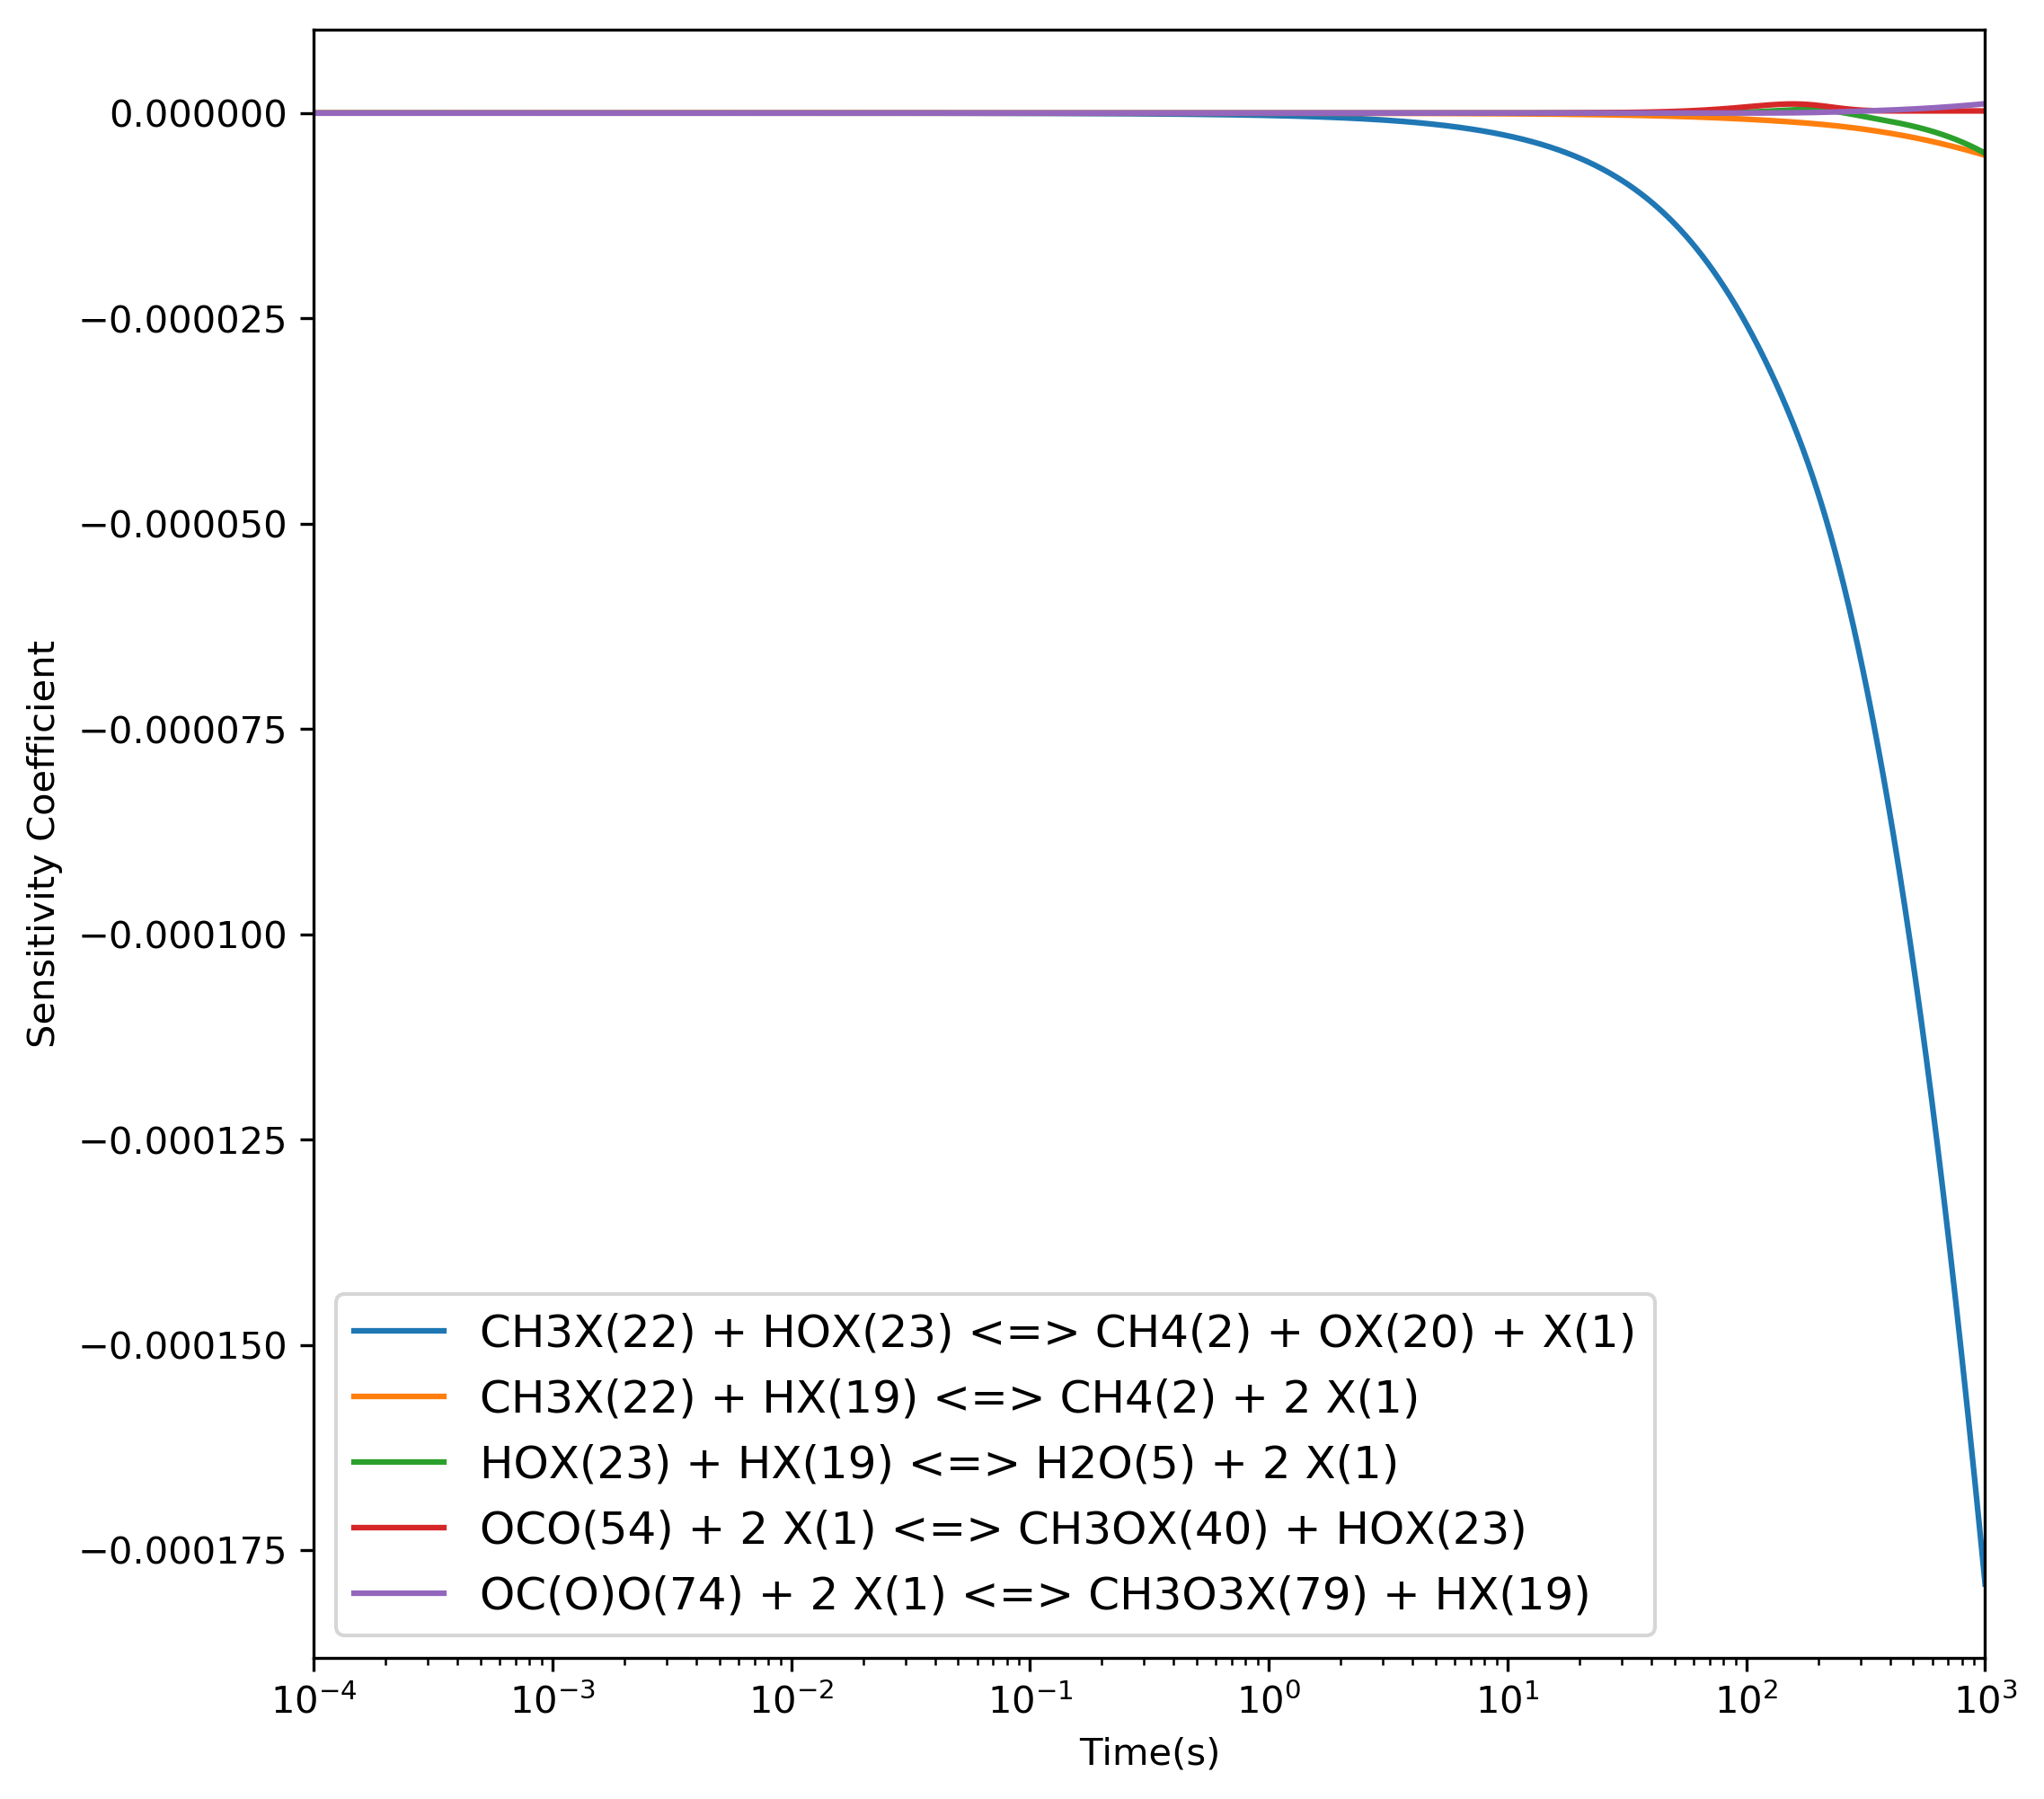

In [4]:
#Plot out simulations results
fig = pylab.figure(dpi=300,figsize=(8,8))
gs = gridspec.GridSpec(1, 1)
ax0 = plt.subplot(gs[0])


for m in range(surf.n_reactions):
    y_max = 0.000001
    if (1==1):
        if max(Sensitivity[m,:])>y_max or min(Sensitivity[m,:])<-y_max:
            lab = surf.reaction_equations()[m]
            ax0.semilogx(rxn_time, Sensitivity[m,:], label=lab )
    else:
        if max(Normed_sensitivity[m,:])>y_max or min(Normed_sensitivity[m,:])<-y_max:
            lab = surf.reaction_equations()[m]
            ax0.semilogx(rxn_time, Normed_sensitivity[m,:], label=lab )
        
ax0.legend(loc='best', fontsize = 12)   
ax0.set_xlim(rxn_time[1], rxn_time[-1] )

ax0.set_xlabel("Time(s)")
ax0.set_ylabel("Sensitivity Coefficient")

In [5]:
# now integrate with respect to time
from numpy import trapz

n = []
p = []
for m in range(surf.n_reactions):
    n.append(trapz(Sensitivity[m,:], rxn_time))#/max(rxn_time)
    p.append(surf.reaction_equations()[m])
#    if ans>1E-3:
#        print "%d %s %.2f"%( m, surf.reaction_equations()[m], ans )

import operator
ans = dict(zip(p,n))
sorted_ans = sorted(ans.items(), key=operator.itemgetter(1), reverse=True)

for x in sorted_ans:
    if x[1]>1E-3:
        print '%s %.3f'%(x)